In [57]:
import pyro
import spotlight
import pandas as pd
import seaborn
from spotlight.cross_validation import random_train_test_split
from spotlight.datasets.movielens import get_movielens_dataset
from spotlight.evaluation import rmse_score
from spotlight.factorization.explicit import ExplicitFactorizationModel
import torch
d = 10

## Load data

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Total length of dataset 100000
num users: 944, num items: 1683


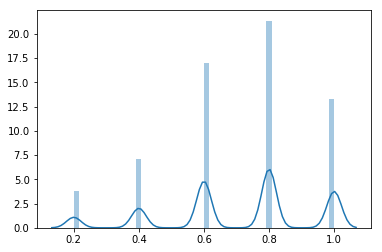

In [58]:
ds = get_movielens_dataset(variant='100K')
ds.ratings = ds.ratings/5
train, test = random_train_test_split(ds)

_ =seaborn.distplot(ds.ratings)
print(f"Total length of dataset {len(ds.ratings)}")
print(f"num users: {ds.num_users}, num items: {ds.num_items}")

## Explicit Matrix Factorization

In [101]:
import torch.nn as nn

from spotlight.layers import ScaledEmbedding, ZeroEmbedding


class BilinearNet(nn.Module):
    """
    Bilinear factorization representation.
    Encodes both users and items as an embedding layer; the score
    for a user-item pair is given by the dot product of the item
    and user latent vectors.
    Parameters
    ----------
    num_users: int
        Number of users in the model.
    num_items: int
        Number of items in the model.
    embedding_dim: int, optional
        Dimensionality of the latent representations.
    user_embedding_layer: an embedding layer, optional
        If supplied, will be used as the user embedding layer
        of the network.
    item_embedding_layer: an embedding layer, optional
        If supplied, will be used as the item embedding layer
        of the network.
    sparse: boolean, optional
        Use sparse gradients.
    """

    def __init__(self, num_users, num_items, embedding_dim=32,
                 user_embedding_layer=None, item_embedding_layer=None, sparse=False):

        super(BilinearNet, self).__init__()

        self.embedding_dim = embedding_dim

        if user_embedding_layer is not None:
            self.user_embeddings = user_embedding_layer
        else:
            self.user_embeddings = ScaledEmbedding(num_users, embedding_dim,
                                                   sparse=sparse)

        if item_embedding_layer is not None:
            self.item_embeddings = item_embedding_layer
        else:
            self.item_embeddings = ScaledEmbedding(num_items, embedding_dim,
                                                   sparse=sparse)

        #self.user_biases = ZeroEmbedding(num_users, 1, sparse=sparse)
        #self.item_biases = ZeroEmbedding(num_items, 1, sparse=sparse)

    def forward(self, user_ids, item_ids):
        """
        Compute the forward pass of the representation.
        Parameters
        ----------
        user_ids: tensor
            Tensor of user indices.
        item_ids: tensor
            Tensor of item indices.
        Returns
        -------
        predictions: tensor
            Tensor of predictions.
        """

        user_embedding = self.user_embeddings(user_ids)
        item_embedding = self.item_embeddings(item_ids)

        user_embedding = user_embedding.squeeze()
        item_embedding = item_embedding.squeeze()

        #user_bias = self.user_biases(user_ids).squeeze()
        #item_bias = self.item_biases(item_ids).squeeze()

        dot = (user_embedding * item_embedding).sum(1)

        return dot #+ user_bias + item_bias

3214.147


In [115]:
print(rmse)

3214.147


## Bayesian MF - one layer
Set hyperpriors to a constant value for simplicity.

In [120]:
network = BilinearNet(num_users = ds.num_users,
           num_items = ds.num_items,
           embedding_dim = d)

model = ExplicitFactorizationModel(n_iter=3, embedding_dim=d, representation=network)
model.fit(train)

rmse = rmse_score(model, test)
print(rmse)

0.20557135


In [121]:
# set priors 
# Set hyperparameters as fixed:
mu_U = mu_V = torch.zeros((d,1))
lambda_U = lambda_V = torch.eye(d)*10
invLambda_V = invLambda_U = lambda_U.inverse()
alpha = 0.1

In [122]:
# Initialize vectors
#U = torch.randn((ds.num_users,d))/100
#V = torch.randn((ds.num_items,d))/100
#model = ExplicitFactorizationModel(n_iter=1, embedding_dim=d)
#model.fit(train)
U = model._net.user_embeddings.weight.data
V = model._net.item_embeddings.weight.data

# Update a user vector of user i
#P( U_i | R, V, mu_U, lambda_U, alpha) (11)

def get_user_moments(userIdx, V, lambda_U, invLambda_V, alpha, ds):
    """
    Calculates equation 12 and 13
    """
    data_idx = ds.user_ids==userIdx
    r = ds.ratings[data_idx]
    item_idx = ds.item_ids[data_idx]
    V_j = V[item_idx]
    
    # get precision vec
    lambda_istar =  lambda_U + alpha*(V_j.unsqueeze(2)*V_j.unsqueeze(1)).sum(0)
    covar = lambda_istar.inverse()
    
    # Get mean vector
    ratings = (V_j*U[userIdx,])
    pvec = alpha*(V_j*ratings).sum(0).unsqueeze(-1) + lambda_U.mm(mu_U)
    mu_istar = covar.mm(pvec)
    return mu_istar, lambda_istar

def get_item_moments(itemIdx, U, lambda_V, invLambda_U, alpha, ds):
    data_idx = ds.item_ids==itemIdx
    r = ds.ratings[data_idx]
    user_idx = ds.user_ids[data_idx]
    U_j = U[user_idx]
    
    lambda_istar =  lambda_V + alpha*(U_j.unsqueeze(2)*U_j.unsqueeze(1)).sum(0)
    covar = lambda_istar.inverse()
    # Get mean vector
    ratings = (U_j*V[itemIdx,])
    pvec = alpha*(U_j*ratings).sum(0).unsqueeze(-1) + lambda_V.mm(mu_V)
    mu_istar = covar.mm(pvec)
    return mu_istar, lambda_istar

In [123]:
for t in range(20):
    # SAMPLE ITEMS
    for i in range(1, ds.num_items):
        mu, covar = get_item_moments(i, U, lambda_V, invLambda_U, alpha, ds)
        mulvarNormal = torch.distributions.MultivariateNormal(mu.view(-1), precision_matrix=covar)
        V[i,] = mulvarNormal.sample()

    # SAMPLE USERS
    for i in range(1, ds.num_users):
        mu, covar = get_user_moments(i, V, lambda_U, invLambda_V, alpha, ds)
        mulvarNormal = torch.distributions.MultivariateNormal(mu.view(-1), precision_matrix=covar)
        U[i,] = mulvarNormal.sample()
        
        
    rmse = rmse_score(model, test)
    print(f" step: {t} \t rmse: {rmse} \t user size {torch.mean(U**2)} \t item size {torch.mean(V**2)}")

 step: 0 	 rmse: 0.7834973335266113 	 user size 0.09343194216489792 	 item size 0.09816313534975052
 step: 1 	 rmse: 0.7942079305648804 	 user size 0.09356163442134857 	 item size 0.09625588357448578
 step: 2 	 rmse: 0.7949645519256592 	 user size 0.09081415086984634 	 item size 0.09730895608663559
 step: 3 	 rmse: 0.7922292351722717 	 user size 0.09400449693202972 	 item size 0.0950855240225792
 step: 4 	 rmse: 0.7919198870658875 	 user size 0.0919126346707344 	 item size 0.09541264921426773
 step: 5 	 rmse: 0.7918428778648376 	 user size 0.09162883460521698 	 item size 0.09581952542066574
 step: 6 	 rmse: 0.7909765243530273 	 user size 0.09232033044099808 	 item size 0.09728484600782394
 step: 7 	 rmse: 0.7928699851036072 	 user size 0.09243365377187729 	 item size 0.0960916131734848
 step: 8 	 rmse: 0.7918943762779236 	 user size 0.0916334018111229 	 item size 0.09487642347812653
 step: 9 	 rmse: 0.7913197875022888 	 user size 0.09024614095687866 	 item size 0.09740480780601501
 ste